In [1]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.layers import Dense, Dropout  
from keras import regularizers 
from keras.models import load_model
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd
import time  
import datetime 
import math
from sklearn.model_selection import KFold
from sklearn import metrics
%run function.py

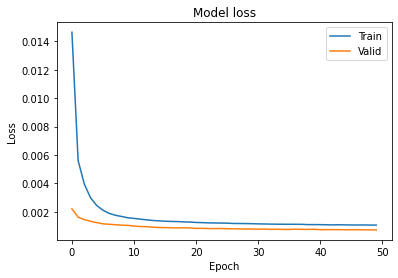

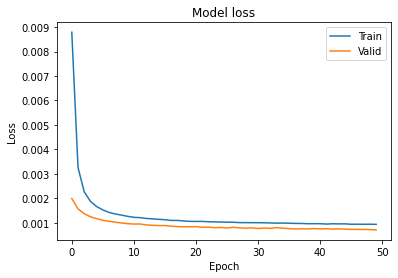

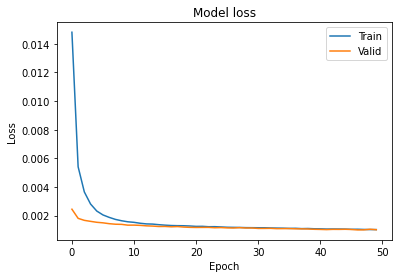

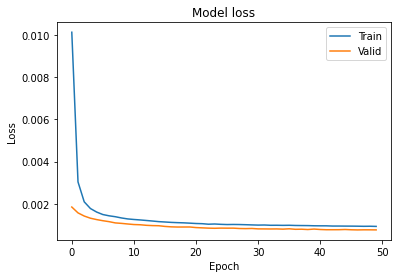

In [4]:
train_data = pd.read_csv("paper_pricing_by_bsm_train.csv")

vol1 = '30days_HV'
#vol2 = '60days_HV'
bs_pricing1 = 'bs_HV30'
bs_pricing2 = 'bs_c60'

for i in train_data.index:
    if train_data.loc[i, bs_pricing1] < 0:
        train_data.loc[i, bs_pricing1] = 0

for i in train_data.index:
    if train_data.loc[i, bs_pricing2] < 0:
        train_data.loc[i, bs_pricing2] = 0        

x = train_data.loc[:, ['T', 'r', 'exercise_price', 'underlying_close', vol1, bs_pricing1, bs_pricing2]]
y = train_data.loc[:, ['close']]

KF = KFold(n_splits = 4)
MSE = []
n = 0
for train_index, val_index in KF.split(x):
    x_train_pd, x_val_pd = x.iloc[train_index, :], x.iloc[val_index, :]
    y_train_pd, y_val_pd = y.iloc[train_index, :], y.iloc[val_index, :]
    
    min_max_scaler = MinMaxScaler()
    
    min_max_scaler.fit(x_train_pd)
    x_train = min_max_scaler.transform(x_train_pd)
    
    min_max_scaler.fit(y_train_pd)
    y_train = min_max_scaler.transform(y_train_pd)
    
    min_max_scaler.fit(x_val_pd)
    x_val = min_max_scaler.transform(x_val_pd)
    
    min_max_scaler.fit(y_val_pd)
    y_val = min_max_scaler.transform(y_val_pd)
    
    model = Sequential()
    model.add(Dense(units = 116, activation='relu', input_shape=(x_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(units = 1, activation='linear')) 
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(x_train, y_train, epochs = 50, batch_size = 1750, verbose = 0, validation_data = (x_val, y_val))
    
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Model loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Valid'], loc='upper right')  
    plt.show()

    n = n + 1
    name = "paper_HNN_30HV_60c_%s.h5" %n
    model.save(name)